In [1]:
%matplotlib notebook

Example trajectory:

Part of a trajectory and the corresponding speed/stimulation plot.

Speed is calculated from the centroid by:

    1) Filtering the x and y coordinates with a half triangular filter (the second half, the negative linear slope) with window size 1 second (30 frames). 

    2) Calculating eucledian distance over time to calculate speed

    3) Filtering the speed using a triangular filter of size 9 (~0.3s)

Scoots are automatically assigned by using the find_peaks function of the scipy.signal library. 

The minimum speed the centroid has achieve to count as a scoot is 2.5mm/s

The minium time to count between scoots was set to 0.165s (5frames)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import json
import matplotlib as mpl
from matplotlib import ticker
from IPython.display import Image
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import pandas as pd
from pathlib import Path
from scipy.signal import argrelextrema, find_peaks
import matplotlib as mpl
import shared_functions

In [3]:
# Option to code time passed in color - for the paper figure this is turned OFF
color_trajectory = False # Set to "true" to get color to indicated time
colormap = 'cool'
cm_colormap = cm.cool
# only plot a fraction to see what's going on
start_plotting = 240 # enter in seconds
end_plotting = 270 # enter number in seconds


In [4]:
home_path = os.getcwd()
# set to True to save plot
save_plot = False

data_path = Path(home_path, 'data/gaussian_arena/01.07.2018_14-25-37_Casper AB/')
# all the figures will be saved in this folder
target_path = Path(home_path, 'plots/')
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [5]:
# Read relevant data
data = pd.read_csv(Path(data_path,'data.csv'))
background = imageio.imread(Path(data_path, 'Background.jpg'))
centroid_positions = np.load(Path(data_path, 'smAL-VR-centroids.npy'))
gauss_virtual_arena = np.genfromtxt(Path(data_path, '640x480_gaussian_centred_animal_pos[250,240,0.0].csv'), delimiter=',')
with open((Path(data_path, 'experiment_settings.json')), 'r') as file:
    experiment_settings = json.load(file)
    pixel_per_mm = experiment_settings['Pixel per mm']
    recording_time = experiment_settings['Recording time']
    fps = experiment_settings['Framerate']

<IPython.core.display.Javascript object>


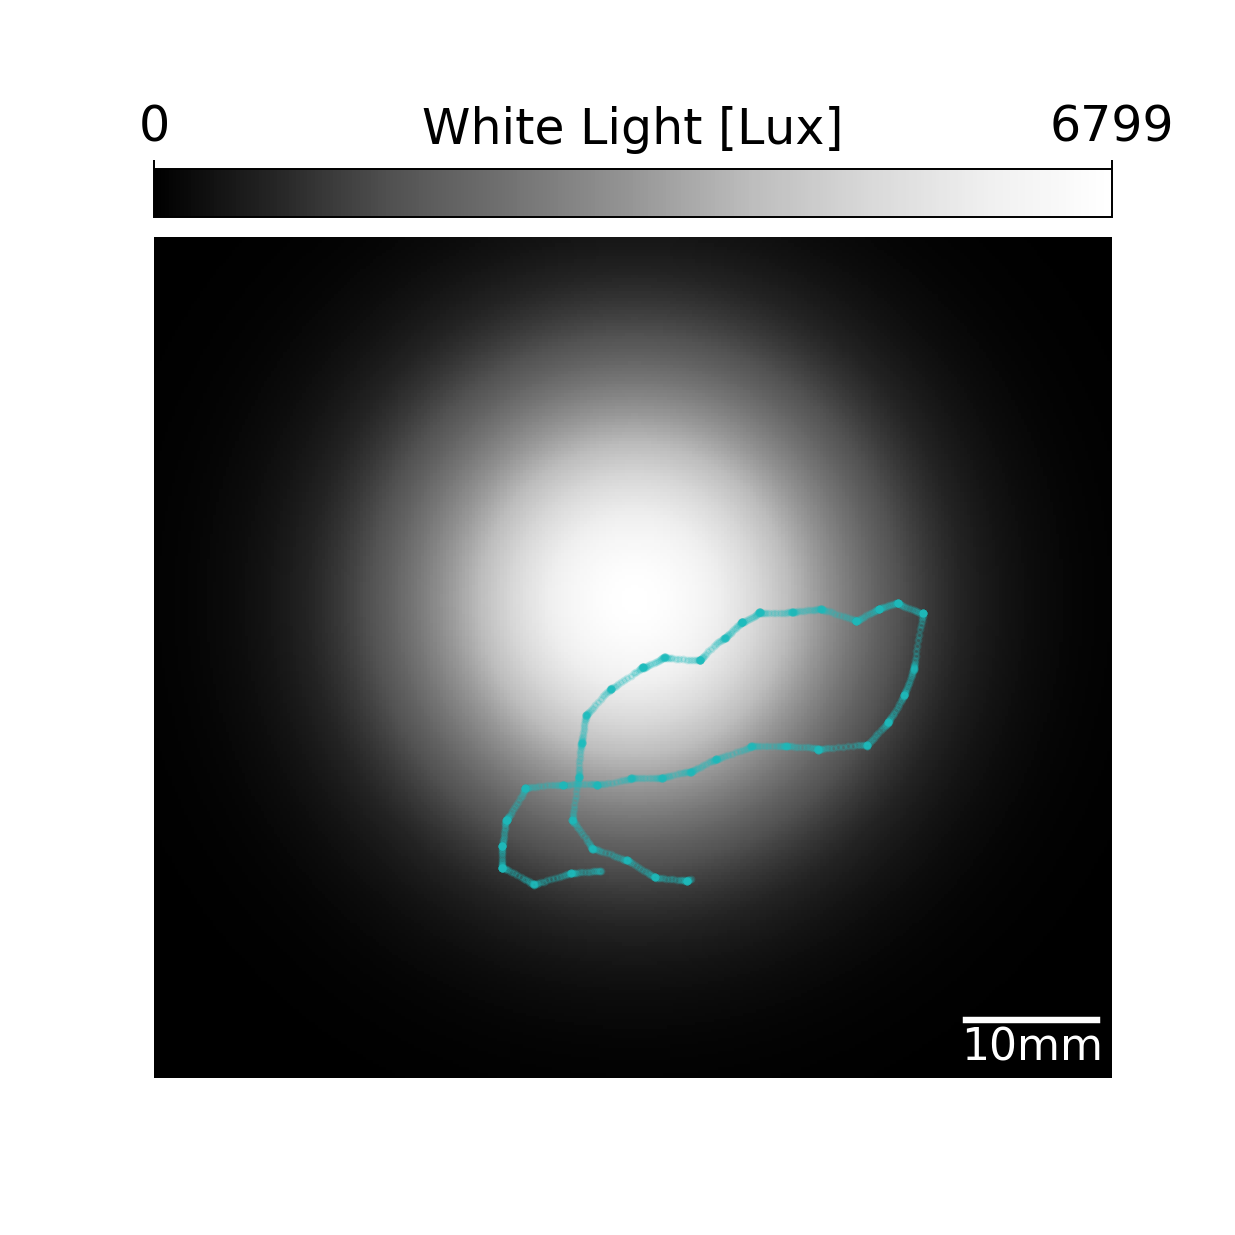

In [6]:
# define the stimulation
# get the virtual arena in Lux
measured_light_intensity = 6800

# max value in stim file is 40000
gauss_arena_in_Lux_mm = gauss_virtual_arena*(measured_light_intensity/40000)
# max value in stim file is 40000
stimulation_in_Lux_mm = data['stimulation']*(measured_light_intensity/40000)

# Get the maximum xy coordinate of the arena (different for different experiment as it depends on the position of the animal)
max_arena_indices_gauss = np.where(gauss_virtual_arena == np.amax(gauss_virtual_arena))
# just the the first one as there are only two anyways and it's only used to center the image
max_arena_indices_gauss = max_arena_indices_gauss[0][0], max_arena_indices_gauss[1][0]
#print(max_arena_index)

# only plot a fraction to see what's going on - take the time provided by the user 
# and multipy by the fps to get the frame numbers
start_plotting *=  fps 
end_plotting *=  fps 

# create empty figure and axis
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
#ax = fig.add_axes([0.1,0.1,0.7,0.7])
ax.set_rasterization_zorder(2)
#ax.imshow(background, cmap='Greys_r')
# plot the virtual arena already in uw/mm
virtual_arena_plot_gauss = ax.imshow(gauss_arena_in_Lux_mm, cmap='Greys_r',zorder=0)
# plot the head positions of the animal
#ax.scatter(x=data['X-Head'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
#          y=data['Y-Head'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
#          alpha = 1, s=1, label = 'Head position')

if color_trajectory:
    colors = cm_colormap(np.linspace(0, 1, end_plotting-start_plotting))
    cmap_centroids = plt.get_cmap(colormap)

    ax.scatter(x=data['X-Centroid'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
            y=data['Y-Centroid'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
           color = colors, alpha = 0.2,zorder = 1,s = 5)
else:
    ax.scatter(x=data['X-Centroid'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
            y=data['Y-Centroid'][start_plotting:end_plotting].rolling(int(fps/2), win_type='triang').mean(),
           color = '#1EBCBD', alpha = 0.2,zorder = 1,s = 5)
       

distance_plotted_from_center = 150
ax.set_ylim(max_arena_indices_gauss[0]-distance_plotted_from_center,max_arena_indices_gauss[0]+distance_plotted_from_center)
ax.set_xlim(max_arena_indices_gauss[1]-distance_plotted_from_center,max_arena_indices_gauss[1]+distance_plotted_from_center)
ax.invert_yaxis()


divider = make_axes_locatable(ax)
if color_trajectory:
    # COLORBAR FOR TIME
    # get the colorbar exactly the same size as the resulting window!

    cax = divider.append_axes('bottom', size='5%', pad='2%')

    norm = mpl.colors.Normalize(vmin=0,vmax=end_plotting-start_plotting)
    sm = plt.cm.ScalarMappable(cmap=cmap_centroids, norm=norm)
    sm.set_array([])
    cbar=fig.colorbar(sm, 
                      orientation="horizontal",
                      ticks=np.linspace(0,end_plotting-start_plotting, 6), 
                      boundaries=np.arange(0,end_plotting+0.1-start_plotting),
                      cax=cax,
                      fraction=0.046, 
                      pad=0.04)
    cbar.set_label('Centroid position at time in seconds', fontsize = 20)
    cbar.ax.set_xticklabels(np.linspace(0,(end_plotting-start_plotting)/30,6, dtype = int), fontsize=20)
    ticklabs = cbar.ax.get_yticklabels()

# COLORBAR FOR STIMULATION
# get the colorbar exactly the same size as the resulting window!
# divider = make_axes_locatable(ax) # DONT UNCOMMENT IF ALREADY DEFINED!
cax = divider.append_axes('top', size='5%', pad='-10%')

# get max of colormap without having an enormous floating point number round to two digits
#max_value_arena_volcano = round(np.amax(arena_in_uW_mm_volcano))
cbar_stim=fig.colorbar(virtual_arena_plot_gauss,
                  orientation="horizontal",
                ticks=[0,np.amax(gauss_arena_in_Lux_mm)],
                  cax=cax,
                  fraction=0.046, 
                  pad=0.04)#, fraction=0.046, pad=0.04)
# change fontsize, to see all parameters that can be changed: print(mpl.rcParams)
cbar_stim.ax.xaxis.set_ticks_position('top')
cbar_stim.ax.set_xticklabels([0,6799], fontsize=20)
cbar_stim.set_label('White Light [Lux]', fontsize = 20, labelpad=-45)
ticklabs = cbar_stim.ax.get_yticklabels()
cbar_stim.ax.set_yticklabels(ticklabs, fontsize=20)
    #cbar_stim.ax.get_yaxis().labelpad = -30

# add scalebar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           10*pixel_per_mm, '10mm', 
                           'lower right',
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
# hide the ticks and the ticklabels
ax.axis('off')

if save_plot:
    #fig.tight_layout()
    if color_trajectory:
        fig.savefig(Path(target_path, 'Fig4b_color.eps'))#, rasterized=True, dpi=300)
    else:
        fig.savefig(Path(target_path, 'Fig4b.eps'))#, rasterized=True, dpi=300)

In [7]:
y = np.asarray(data['Y-Centroid'])
x = np.asarray(data['X-Centroid'])

# filter x/y coordinates using the half-triangle
centroid_filt_y =  np.floor(np.convolve(y,shared_functions.constants.kernel_centroid,'same'))
centroid_filt_x =  np.floor(np.convolve(x,shared_functions.constants.kernel_centroid,'same'))
centroid_filt = np.asarray((centroid_filt_y, centroid_filt_x)).T
# calculated speed:
centroid_speed_filt = []
for i_speed in range(centroid_filt.shape[0]):
    centroid_speed_filt.append((
        np.linalg.norm(centroid_filt[i_speed, :,] 
                       - centroid_filt[i_speed - 1,:]) 
                       / pixel_per_mm) * fps)

# list to numpy array:
centroid_speed_filt = np.asarray(centroid_speed_filt)
# convolve to do the triangular filtering
filt_centroid_speed_filt =  np.convolve(centroid_speed_filt,shared_functions.constants.kernel_speed,'same')

# Ause the supplied scipy function directly on the array
identified_scoots,temp = find_peaks(x = filt_centroid_speed_filt,
                                    height = shared_functions.constants.speed_scoot,
                                    distance = shared_functions.constants.min_frames_between_scoots
                                    )
# Needed for plotting
def frame_to_time(x, pos):
    """
    The two args are the value and tick position
    The first string defines what is shown. %1.1f means that only the first decimal is shown
    x/fps means that for each 'tick', meaning each datapoint the value that is shown is divided by the frames per second.
    This way the actual seconds are displayed
    """
    # CAREFUL!!! was '%1.1f', the 0 makes sure only the value before the decimal dot is shown!!!
    # Make sure your ticks are really integers! 
    return '%1.0f' % (x/fps) # 

# Take a handy slice of the filtered speed and the stimulation of the time we want to plot!
relevant_filt_centroid_speed_filt = filt_centroid_speed_filt[start_plotting:end_plotting]
relevant_stimulation = np.asarray(stimulation_in_Lux_mm[start_plotting:end_plotting])

<IPython.core.display.Javascript object>


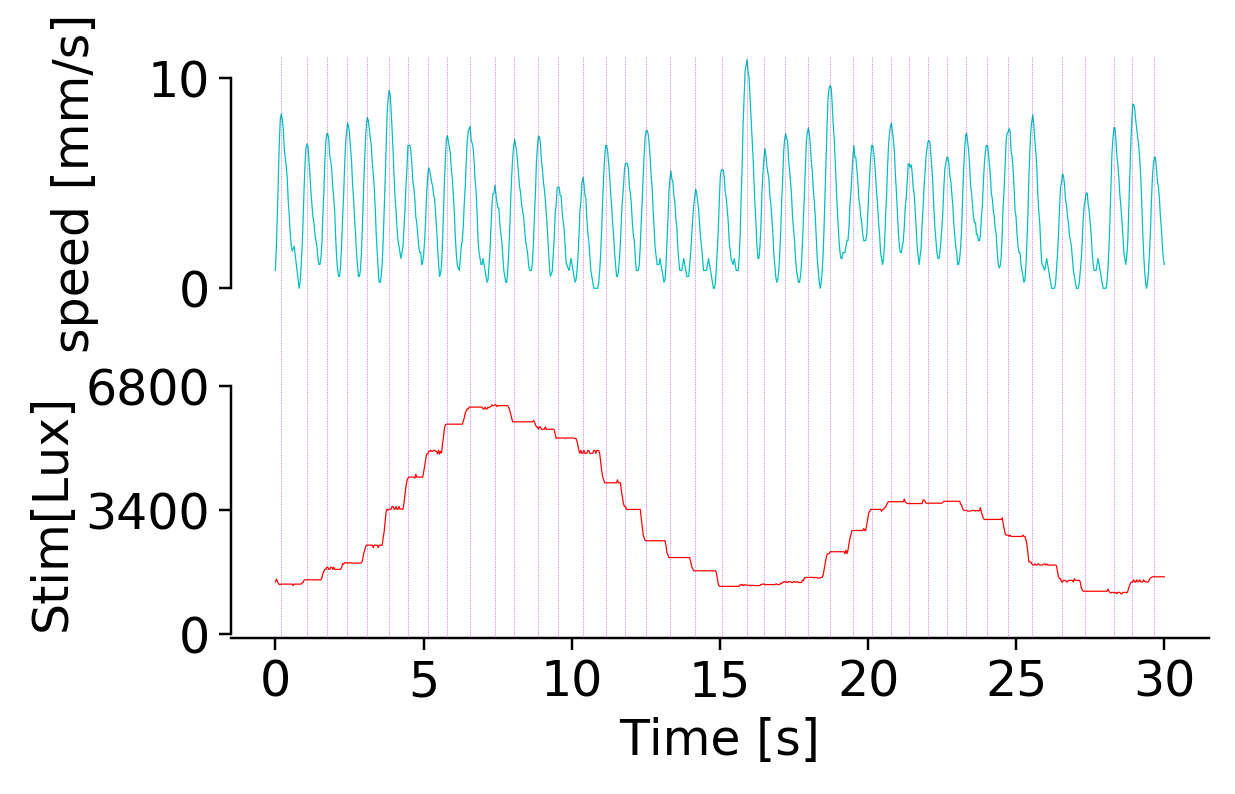

In [8]:
if color_trajectory:
    colorful_speed = True
else:
    colorful_speed = False

fig = plt.figure(figsize=(7,4.5))

bottom_axis_min_y = -100
top_axis_max_y = 11

ax_top = fig.add_subplot(211)
ax_top.set_rasterization_zorder(1)
ax_top.patch.set_alpha(0)

# Organize the x axis to directly display time
x = np.linspace(0,relevant_filt_centroid_speed_filt.shape[0]/fps, \
                int((relevant_filt_centroid_speed_filt.shape[0])))
    
if colorful_speed:
    # Now do a second plot coloring the curve using a continuous colormap
    y = relevant_filt_centroid_speed_filt
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap(colormap),
                        #norm=plt.Normalize(0, 10)
                       )
    lc.set_array(x)
    lc.set_linewidth(0.5)
    
    ax_top.add_collection(lc)
else:
    centroid_plotted, = ax_top.plot(x,
                                    relevant_filt_centroid_speed_filt,
                                    label = 'Centroid speed', 
                                    color='c', 
                                    lw=0.5)

ax_top.tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off)
ax_top.set_ylabel('speed [mm/s]', fontsize=20)
# change the location of the label
ax_top.get_yaxis().labelpad = 20
# can change x ticklabel size here
ax_top.tick_params(axis='y', labelsize=20)

ax_bottom = fig.add_subplot(212, sharex = ax_top)
ax_bottom.patch.set_alpha(0)
ax_bottom.set_rasterization_zorder(1)
if colorful_speed:
    stim_plotted, = ax_bottom.plot(x,
                                   relevant_stimulation, color ='r',
                                   label='Stimulation',lw=0.5)
else:
    stim_plotted, = ax_bottom.plot(x,
                                   relevant_stimulation, 
                                   color ='r',
                                   label='Stimulation',
                                   lw=0.5)

ax_bottom.set_ylabel('Stim[Lux]', fontsize=20)
# label the x axis
ax_bottom.set_xlabel('Time [s]', fontsize=20)
# can change x ticklabel size here
ax_bottom.tick_params(axis='x', labelsize=20)
# can change y ticklable size here
ax_bottom.tick_params(axis='y', labelsize=20)

# TOP PLOT SPINES
# Only draw spine between the y-ticks
ax_top.spines['left'].set_bounds(0, top_axis_max_y-1)
ax_top.spines['right'].set_visible(False)
ax_top.spines['top'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
ax_top.tick_params(axis='both', which='major', width=1, length =5)
#ax_top.tick_params(axis='both', which='minor', width =2,length =3)

# BOTTOM PLOT SPINES
# Only draw spine between the y-ticks
ax_bottom.spines['left'].set_bounds(0, measured_light_intensity)
ax_bottom.spines['right'].set_visible(False)
ax_bottom.spines['top'].set_visible(False)
ax_bottom.spines['bottom'].set_linewidth(1)
ax_bottom.spines['left'].set_linewidth(1)
# We change the fontsize of minor ticks label 
ax_bottom.tick_params(axis='both', which='major', width=1, length =5)
#ax_bottom.tick_params(axis='both', which='minor', width =2,length =3)

#ax_top.set_xlim(0,30)


ax_top.set_ylim(-1,top_axis_max_y)
ax_bottom.set_ylim(bottom_axis_min_y, measured_light_intensity)
ax_bottom.yaxis.set_ticks(np.arange(0, measured_light_intensity+1, measured_light_intensity/2))
#ax_bottom.set_xticklabels([0,10,20,30])
# need to call the tight_layout BEFORE doing anything at the figure level! 
fig.tight_layout()

# only works after running scoot detection!
first_iteration = True
fig.lines = []
transFigure = fig.transFigure.inverted()

# As everything go plotted relative to the 'start_plotting' variable, need to correct
# the scoots
relevant_scoots = identified_scoots[np.where((identified_scoots>start_plotting) 
                                             & (identified_scoots<end_plotting))[0]]
# bring into second time domain
relevant_scoots = (relevant_scoots/fps) - (start_plotting/fps)

for i_indicate_scoots in range(relevant_scoots.shape[0]):
    #if start_plotting < identified_scoots[i_indicate_scoots] < end_plotting:
    
    #coord1 = transFigure.transform(ax_top.transData.transform([identified_scoots[i_indicate_scoots]/fps,
    #                                                           top_axis_max_y]))
    #coord2 = transFigure.transform(ax_bottom.transData.transform([identified_scoots[i_indicate_scoots]/fps,
    #                                                              bottom_axis_min_y]))
    coord1 = transFigure.transform(ax_top.transData.transform([relevant_scoots[i_indicate_scoots],
                                                               top_axis_max_y]))
    coord2 = transFigure.transform(ax_bottom.transData.transform([relevant_scoots[i_indicate_scoots],
                                                                  bottom_axis_min_y]))

    if first_iteration:
        first_line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                                       transform=fig.transFigure, color='m',ls=':',alpha =1,zorder=0,
                                       label='Scoot',lw=0.25)
        fig.lines.append(first_line)
        first_iteration = False
    else:
        line = mpl.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),
                                       transform=fig.transFigure, color='m',ls=':',alpha =1,zorder=0,
                                       lw=0.25)

        fig.lines.append(line)
        
#handles_top, labels_top = ax_top.get_legend_handles_labels()
#handles_bottom, labels_bottom = ax_bottom.get_legend_handles_labels()

if save_plot:
    #fig.legend(handles=[centroid_plotted, first_line, stim_plotted])
    if colorful_speed:
        fig.savefig(Path(target_path, 'Fig4c_colorful.eps'))#, rasterized=True, dpi=300)
    else:
        fig.savefig(Path(target_path, 'Fig4c.eps'))#, rasterized=True, dpi=300)